In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState

c:\Users\Amand\OneDrive\Documentos\VSCode\RedesNeurais\RN-Airline-Passenger-Satisfaction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

##### Declarando as funções de metricas

In [4]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [5]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [7]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Criando o modelo MLP

In [8]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(2, activation='softmax')
])

In [9]:
model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852 (7.23 KB)

 Trainable params: 1,852 (7.23 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train,
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8339 - loss: 0.3866 - val_accuracy: 0.9059 - val_loss: 0.2387
Epoch 2/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - accuracy: 0.9042 - loss: 0.2422 - val_accuracy: 0.9203 - val_loss: 0.2003
Epoch 3/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 745us/step - accuracy: 0.9185 - loss: 0.1978 - val_accuracy: 0.9339 - val_loss: 0.1698
Epoch 4/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9257 - loss: 0.1818 - val_accuracy: 0.9360 - val_loss: 0.1574
Epoch 5/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step - accuracy: 0.9299 - loss: 0.1694 - val_accuracy: 0.9396 - val_loss: 0.1500
Epoch 6/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 703us/step - accuracy: 0.9325 - loss: 0.1582 - val_accuracy: 0.9423 - val_loss: 0.1431
Epoch 7/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 710us/step - accuracy: 0.9351 - loss: 0.1556 - val_accuracy: 0.9395 - val_loss: 0.1459
Epoch 8/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9376 - loss:

##### Avaliando o modelo

In [13]:
mlp_pred_scores = model.predict(X_test)
mlp_pred_class = np.argmax(mlp_pred_scores, axis=1)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


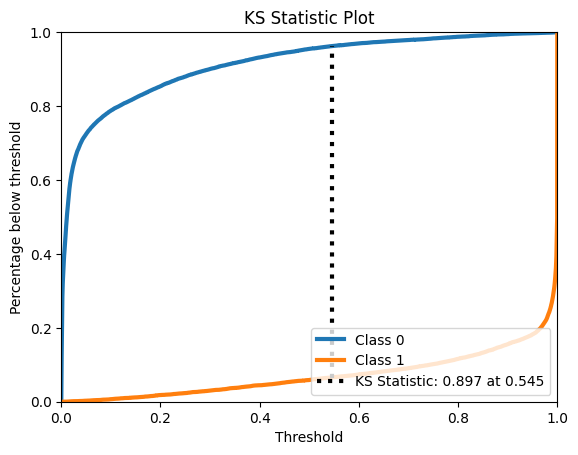



Multi Layer Perceptron - Test

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9905
AUPR:             0.9889


In [14]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('\n\nMulti Layer Perceptron - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

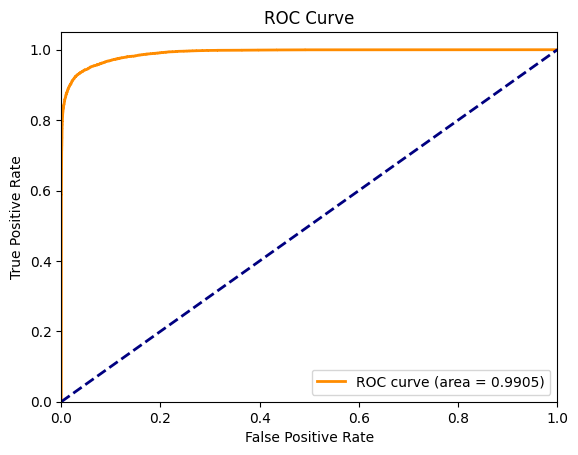

In [15]:
plot_roc_curve(mlp_pred_scores, y_test)

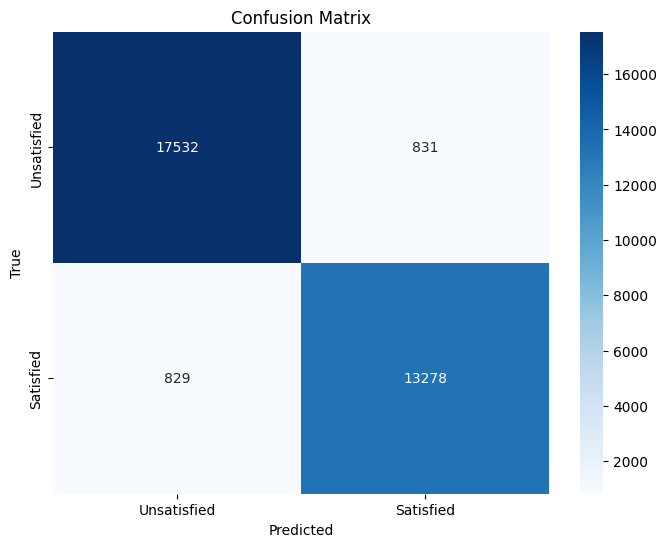

In [16]:
plot_confusion_matrix(y_pred=mlp_pred_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC e o K-S

In [23]:
def objective(trial):

    global x_train
    global y_train

    global X_val
    global y_val

    global X_test
    global y_test

    global early_stopping
    
    params = {
        'n_hidden_layers': trial.suggest_int('n_hidden_layers', 10, 500, step=10),
        'activation_function' : trial.suggest_categorical('activation_function', ['relu', 'sigmoid', 'softmax', 'tanh']),
        'optimizer' : trial.suggest_categorical('optimizer', ['adam', 'SGD', 'rmsprop']),
        'batch_size': trial.suggest_int('batch_size', 32, 160, step=32)
    }

    trial.set_user_attr("n_hidden_layers", params["n_hidden_layers"])
    trial.set_user_attr("activation_function", params["activation_function"])
    trial.set_user_attr("optimizer", params["optimizer"])
    trial.set_user_attr("batch_size", params["batch_size"])

    model = Sequential([
        # Input layer
        Input(shape=(X_train.shape[1],)),

        # Hidden layers
        Dense(params['n_hidden_layers'], activation=params['activation_function']),
        Dropout(0.2),

        # Output layer
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=params['optimizer'], 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    history = model.fit(
        X_train,
        y_train, 
        epochs=100, 
        batch_size=params['batch_size'], 
        validation_data=(X_val, y_val), 
        callbacks=[early_stopping]
    )

    y_pred_test_scores = model.predict(X_test)
    y_pred_test_class = np.argmax(mlp_pred_scores, axis=1)
    
    # Avaliar o modelo usando test k-s
    # y_pred_test_scores = model.predict(X_test, batch_size=params['batch_size'])
    # prob_class_0 = 1 - y_pred_test_scores

    # y_pred_test_scores = np.hstack((prob_class_0, y_pred_test_scores))
    # y_pred_test_class = np.argmax(y_pred_test_scores, axis=1)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, y_pred_test_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nMLP\nn_hidden_layers: {params["n_hidden_layers"]}\nactivation_function:{params["activation_function"]}\noptimizer:{params["optimizer"]}\nbatch_size:{params["batch_size"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    return auroc, ks_statistic


[I 2024-07-29 17:26:28,776] A new study created in memory with name: no-name-67e133a7-71e6-4fd8-8521-4811f7a8769c


Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8195 - loss: 0.4148 - val_accuracy: 0.8721 - val_loss: 0.3375
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - accuracy: 0.8638 - loss: 0.3457 - val_accuracy: 0.8722 - val_loss: 0.3265
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.8683 - loss: 0.3340 - val_accuracy: 0.8795 - val_loss: 0.3107
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8749 - loss: 0.3169 - val_accuracy: 0.8900 - val_loss: 0.2786
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8787 - loss: 0.3007 - val_accuracy: 0.8972 - val_loss: 0.2666
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step


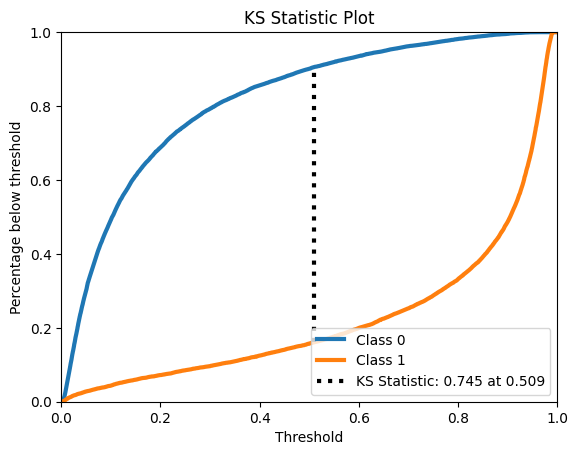

[I 2024-07-29 17:26:36,029] Trial 0 finished with values: [0.9294778043635745, 0.7450288266591909] and parameters: {'n_hidden_layers': 50, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 50
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9295
AUPR:             0.9336
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - accuracy: 0.7606 - loss: 0.5661 - val_accuracy: 0.8597 - val_loss: 0.3546
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 875us/step - accuracy: 0.8500 - loss: 0.3665 - val_accuracy: 0.8753 - val_loss: 0.3195
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 820us/step - accuracy: 0.8620 - loss: 0.3425 - val_accuracy: 0.8841 - val_loss: 0.2989
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 842us/step - accuracy: 0.8719 - loss: 0.3264 - val_accuracy: 0.8901 - val_loss: 0.2827
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 854us/step - accuracy: 0.8805 - loss: 0.3090 - val_accuracy: 0.8958 - val_loss: 0.2671
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step


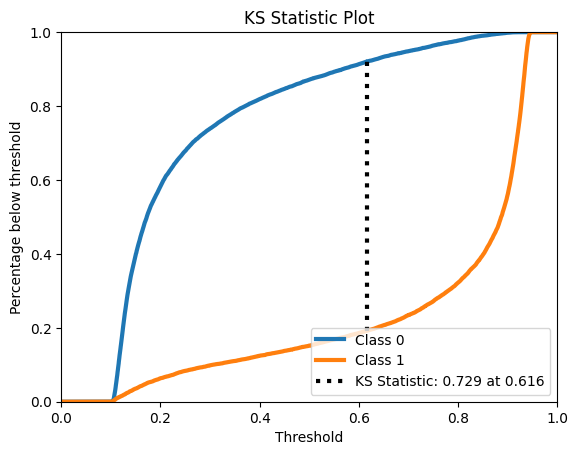

[I 2024-07-29 17:26:47,238] Trial 1 finished with values: [0.9238073240970346, 0.7288195728277574] and parameters: {'n_hidden_layers': 190, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 190
activation_function:softmax
optimizer:rmsprop
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9238
AUPR:             0.9284
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8431 - loss: 0.3822 - val_accuracy: 0.8598 - val_loss: 0.3457
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8631 - loss: 0.3547 - val_accuracy: 0.8725 - val_loss: 0.3247
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step - accuracy: 0.8684 - loss: 0.3320 - val_accuracy: 0.8927 - val_loss: 0.2796
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.8800 - loss: 0.2959 - val_accuracy: 0.9007 - val_loss: 0.2498
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 844us/step - accuracy: 0.8873 - loss: 0.2741 - val_accuracy: 0.9068 - val_loss: 0.2357
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step


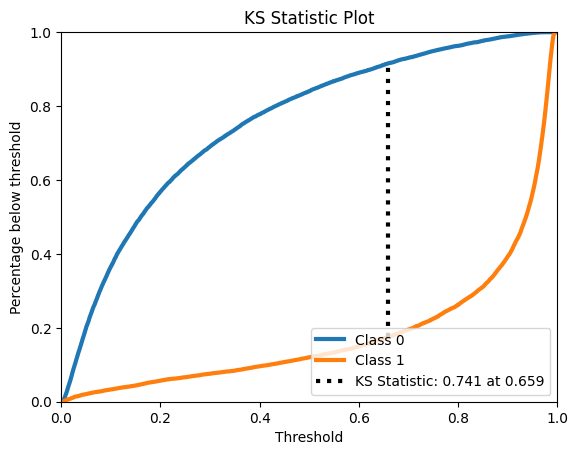

[I 2024-07-29 17:26:59,536] Trial 2 finished with values: [0.927603542943803, 0.7408387581919982] and parameters: {'n_hidden_layers': 460, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 460
activation_function:tanh
optimizer:adam
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9276
AUPR:             0.9318
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8020 - loss: 0.4376 - val_accuracy: 0.8664 - val_loss: 0.3415
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.8620 - loss: 0.3578 - val_accuracy: 0.8705 - val_loss: 0.3368
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.8637 - loss: 0.3465 - val_accuracy: 0.8700 - val_loss: 0.3307
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.8650 - loss: 0.3381 - val_accuracy: 0.8466 - val_loss: 0.3525
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.8698 - loss: 0.3289 - val_accuracy: 0.8826 - val_loss: 0.3049
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


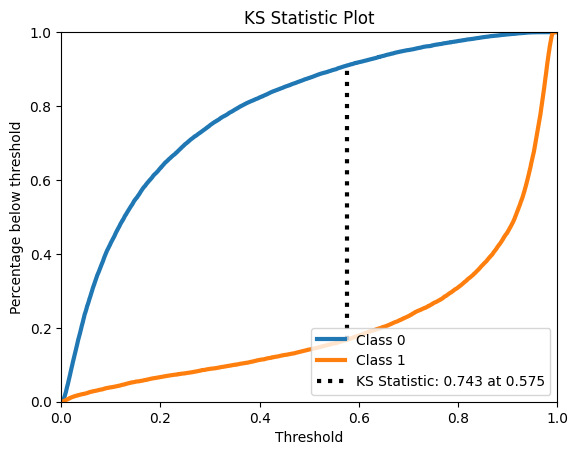

[I 2024-07-29 17:27:03,578] Trial 3 finished with values: [0.9277095334275859, 0.742624400503691] and parameters: {'n_hidden_layers': 120, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 120
activation_function:tanh
optimizer:rmsprop
batch_size:160

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9277
AUPR:             0.9319
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7631 - loss: 0.5160 - val_accuracy: 0.8333 - val_loss: 0.3978
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8339 - loss: 0.3976 - val_accuracy: 0.8543 - val_loss: 0.3639
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8509 - loss: 0.3695 - val_accuracy: 0.8608 - val_loss: 0.3522
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8590 - loss: 0.3600 - val_accuracy: 0.8608 - val_loss: 0.3485
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8600 - loss: 0.3557 - val_accuracy: 0.8683 - val_loss: 0.3466
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step


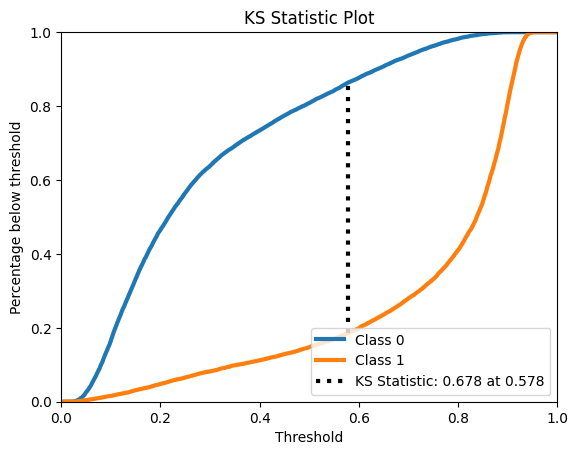

[I 2024-07-29 17:27:09,220] Trial 4 finished with values: [0.9095896463759617, 0.6779051013403402] and parameters: {'n_hidden_layers': 420, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 128}. 




MLP
n_hidden_layers: 420
activation_function:tanh
optimizer:SGD
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9096
AUPR:             0.9103
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7412 - loss: 0.6022 - val_accuracy: 0.8572 - val_loss: 0.3835
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8524 - loss: 0.3841 - val_accuracy: 0.8695 - val_loss: 0.3364
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8627 - loss: 0.3498 - val_accuracy: 0.8747 - val_loss: 0.3199
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8671 - loss: 0.3363 - val_accuracy: 0.8792 - val_loss: 0.3032
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8731 - loss: 0.3195 - val_accuracy: 0.8856 - val_loss: 0.2809
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step


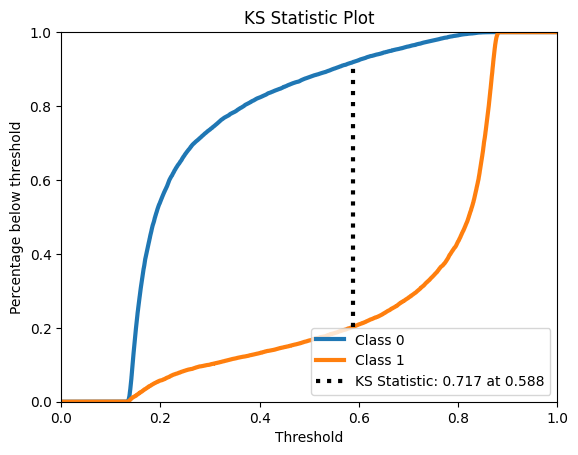

[I 2024-07-29 17:27:16,097] Trial 5 finished with values: [0.9207899624608817, 0.7169997529520153] and parameters: {'n_hidden_layers': 440, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 96}. 




MLP
n_hidden_layers: 440
activation_function:softmax
optimizer:adam
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9208
AUPR:             0.9244
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6559 - loss: 0.6659 - val_accuracy: 0.8140 - val_loss: 0.4970
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8070 - loss: 0.4769 - val_accuracy: 0.8493 - val_loss: 0.3896
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8468 - loss: 0.3902 - val_accuracy: 0.8655 - val_loss: 0.3456
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8551 - loss: 0.3621 - val_accuracy: 0.8712 - val_loss: 0.3290
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8610 - loss: 0.3487 - val_accuracy: 0.8733 - val_loss: 0.3209
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step


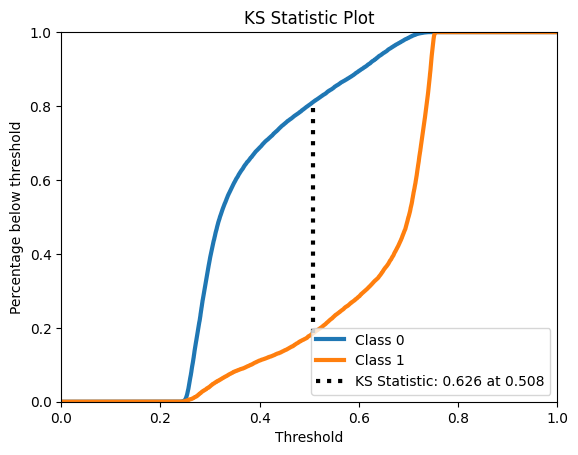

[I 2024-07-29 17:27:20,779] Trial 6 finished with values: [0.8926621672255791, 0.6261758042438356] and parameters: {'n_hidden_layers': 200, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 200
activation_function:softmax
optimizer:rmsprop
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8927
AUPR:             0.8894
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6063 - loss: 0.6569 - val_accuracy: 0.7748 - val_loss: 0.5412
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7540 - loss: 0.5326 - val_accuracy: 0.8070 - val_loss: 0.4551
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7797 - loss: 0.4860 - val_accuracy: 0.8186 - val_loss: 0.4241
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7924 - loss: 0.4638 - val_accuracy: 0.8290 - val_loss: 0.4073
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8055 - loss: 0.4444 - val_accuracy: 0.8352 - val_loss: 0.3953
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


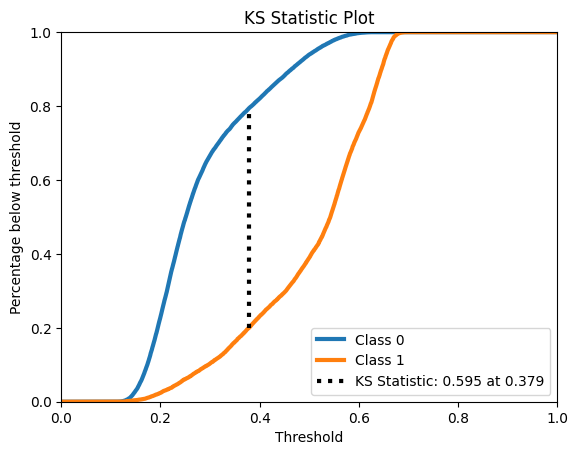

[I 2024-07-29 17:27:26,985] Trial 7 finished with values: [0.8817933568238341, 0.5949256103841081] and parameters: {'n_hidden_layers': 370, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 370
activation_function:sigmoid
optimizer:SGD
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8818
AUPR:             0.8737
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6338 - loss: 0.6846 - val_accuracy: 0.8196 - val_loss: 0.5737
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7938 - loss: 0.5362 - val_accuracy: 0.8301 - val_loss: 0.4340
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8166 - loss: 0.4366 - val_accuracy: 0.8578 - val_loss: 0.3737
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8396 - loss: 0.3880 - val_accuracy: 0.8661 - val_loss: 0.3439
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8518 - loss: 0.3677 - val_accuracy: 0.8683 - val_loss: 0.3360
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step


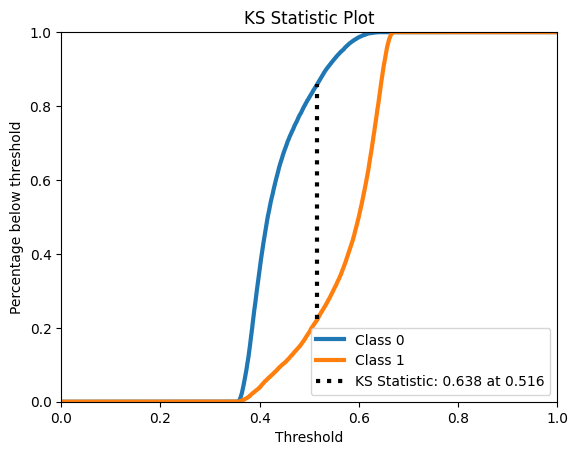

[I 2024-07-29 17:27:31,371] Trial 8 finished with values: [0.8954567042954212, 0.6379122106337518] and parameters: {'n_hidden_layers': 350, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 350
activation_function:softmax
optimizer:rmsprop
batch_size:160

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8955
AUPR:             0.8943
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - accuracy: 0.6652 - loss: 0.6067 - val_accuracy: 0.8201 - val_loss: 0.4244
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step - accuracy: 0.7975 - loss: 0.4568 - val_accuracy: 0.8374 - val_loss: 0.3886
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8180 - loss: 0.4236 - val_accuracy: 0.8530 - val_loss: 0.3739
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step - accuracy: 0.8288 - loss: 0.4059 - val_accuracy: 0.8576 - val_loss: 0.3680
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - accuracy: 0.8377 - loss: 0.3961 - val_accuracy: 0.8576 - val_loss: 0.3620
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


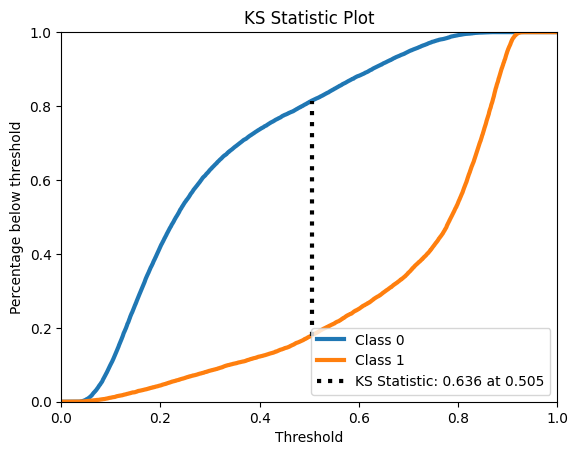

[I 2024-07-29 17:27:43,628] Trial 9 finished with values: [0.8978790210377435, 0.6356822046712394] and parameters: {'n_hidden_layers': 370, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 32}. 




MLP
n_hidden_layers: 370
activation_function:sigmoid
optimizer:SGD
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8979
AUPR:             0.8962
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - accuracy: 0.8112 - loss: 0.4291 - val_accuracy: 0.8615 - val_loss: 0.3490
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.8567 - loss: 0.3653 - val_accuracy: 0.8673 - val_loss: 0.3581
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 870us/step - accuracy: 0.8615 - loss: 0.3547 - val_accuracy: 0.8684 - val_loss: 0.3361
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - accuracy: 0.8614 - loss: 0.3477 - val_accuracy: 0.8686 - val_loss: 0.3290
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - accuracy: 0.8663 - loss: 0.3369 - val_accuracy: 0.8677 - val_loss: 0.3348
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step


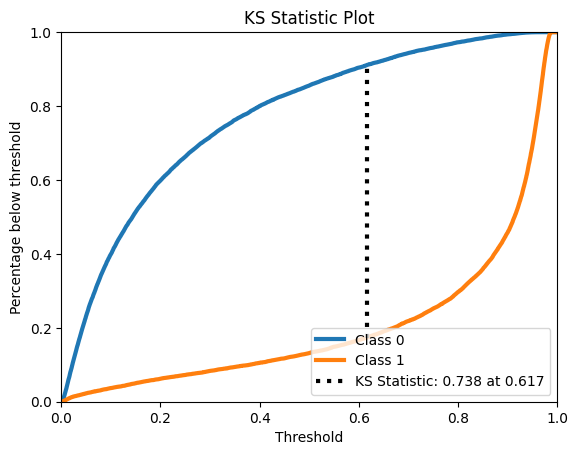

[I 2024-07-29 17:27:54,809] Trial 10 finished with values: [0.9264301721401806, 0.7376708176109354] and parameters: {'n_hidden_layers': 360, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 360
activation_function:sigmoid
optimizer:rmsprop
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9264
AUPR:             0.9307
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8143 - loss: 0.4232 - val_accuracy: 0.8614 - val_loss: 0.3408
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.8620 - loss: 0.3520 - val_accuracy: 0.8654 - val_loss: 0.3324
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.8706 - loss: 0.3348 - val_accuracy: 0.8798 - val_loss: 0.3132
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8723 - loss: 0.3210 - val_accuracy: 0.8798 - val_loss: 0.2963
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.8766 - loss: 0.3098 - val_accuracy: 0.8968 - val_loss: 0.2671
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step


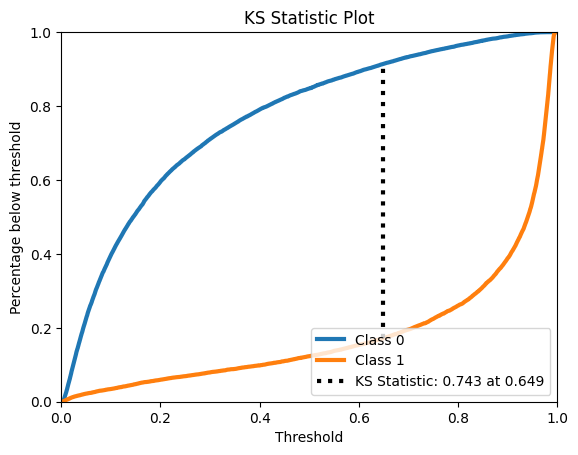

[I 2024-07-29 17:27:59,462] Trial 11 finished with values: [0.9285674670705597, 0.7426949205684388] and parameters: {'n_hidden_layers': 70, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 70
activation_function:tanh
optimizer:rmsprop
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9286
AUPR:             0.9330
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.6626 - val_accuracy: 0.7937 - val_loss: 0.5277
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.7488 - loss: 0.5380 - val_accuracy: 0.8072 - val_loss: 0.4612
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7790 - loss: 0.4882 - val_accuracy: 0.8161 - val_loss: 0.4379
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7912 - loss: 0.4628 - val_accuracy: 0.8201 - val_loss: 0.4138
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8003 - loss: 0.4499 - val_accuracy: 0.8177 - val_loss: 0.4089
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step


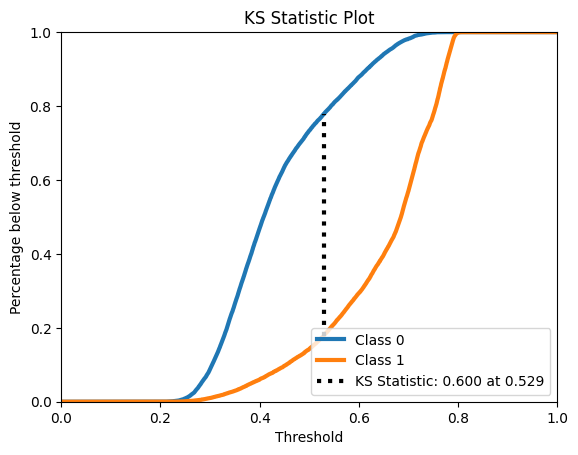

[I 2024-07-29 17:28:05,655] Trial 12 finished with values: [0.8794480628312313, 0.60010513697019] and parameters: {'n_hidden_layers': 320, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 320
activation_function:sigmoid
optimizer:SGD
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8794
AUPR:             0.8712
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step - accuracy: 0.7950 - loss: 0.4515 - val_accuracy: 0.8610 - val_loss: 0.3476
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - accuracy: 0.8606 - loss: 0.3573 - val_accuracy: 0.8582 - val_loss: 0.3481
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 777us/step - accuracy: 0.8623 - loss: 0.3521 - val_accuracy: 0.8653 - val_loss: 0.3421
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.8639 - loss: 0.3511 - val_accuracy: 0.8708 - val_loss: 0.3428
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 807us/step - accuracy: 0.8649 - loss: 0.3477 - val_accuracy: 0.8640 - val_loss: 0.3419
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step


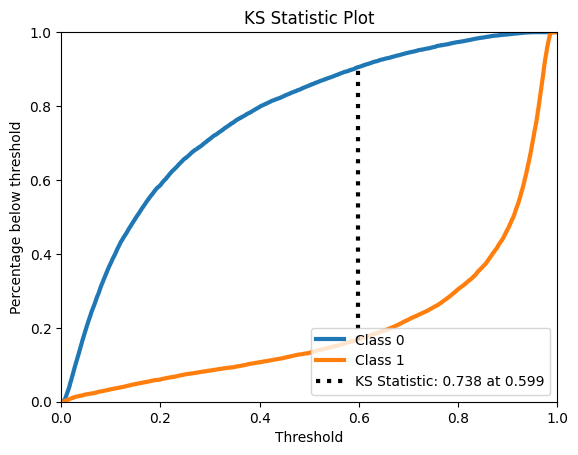

[I 2024-07-29 17:28:16,562] Trial 13 finished with values: [0.9260470252173428, 0.7379946046128391] and parameters: {'n_hidden_layers': 290, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 32}. 




MLP
n_hidden_layers: 290
activation_function:tanh
optimizer:SGD
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9260
AUPR:             0.9303
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 991us/step - accuracy: 0.8029 - loss: 0.4389 - val_accuracy: 0.8666 - val_loss: 0.3483
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.8574 - loss: 0.3597 - val_accuracy: 0.8691 - val_loss: 0.3397
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.8627 - loss: 0.3491 - val_accuracy: 0.8678 - val_loss: 0.3291
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8691 - loss: 0.3280 - val_accuracy: 0.8844 - val_loss: 0.2910
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step - accuracy: 0.8856 - loss: 0.2888 - val_accuracy: 0.9028 - val_loss: 0.2465
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step


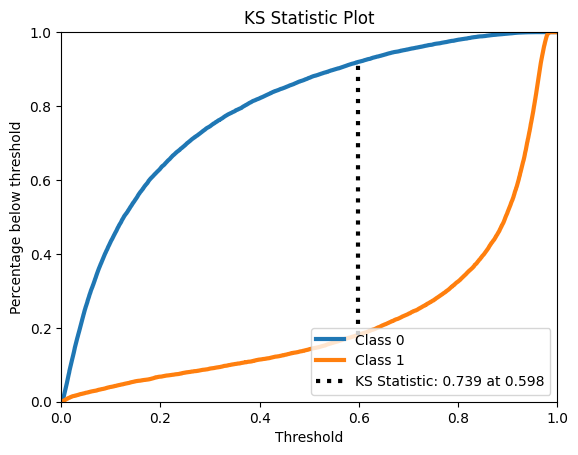

[I 2024-07-29 17:28:28,910] Trial 14 finished with values: [0.9269599122422806, 0.739203748869495] and parameters: {'n_hidden_layers': 180, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 180
activation_function:sigmoid
optimizer:adam
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9270
AUPR:             0.9313
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8385 - loss: 0.3883 - val_accuracy: 0.8393 - val_loss: 0.3700
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8616 - loss: 0.3531 - val_accuracy: 0.8700 - val_loss: 0.3488
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8643 - loss: 0.3491 - val_accuracy: 0.8739 - val_loss: 0.3269
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8653 - loss: 0.3394 - val_accuracy: 0.8849 - val_loss: 0.2998
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8748 - loss: 0.3178 - val_accuracy: 0.8848 - val_loss: 0.2948
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step


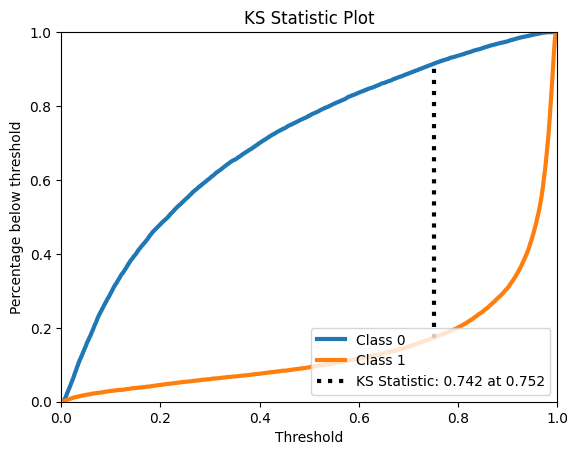

[I 2024-07-29 17:28:36,707] Trial 15 finished with values: [0.9274140250951757, 0.7417170896903544] and parameters: {'n_hidden_layers': 390, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 390
activation_function:tanh
optimizer:rmsprop
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9274
AUPR:             0.9320
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.7646 - loss: 0.4856 - val_accuracy: 0.8655 - val_loss: 0.3580
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.8524 - loss: 0.3708 - val_accuracy: 0.8592 - val_loss: 0.3491
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.8575 - loss: 0.3605 - val_accuracy: 0.8640 - val_loss: 0.3428
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.8616 - loss: 0.3558 - val_accuracy: 0.8698 - val_loss: 0.3368
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.8640 - loss: 0.3480 - val_accuracy: 0.8677 - val_loss: 0.3325
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step


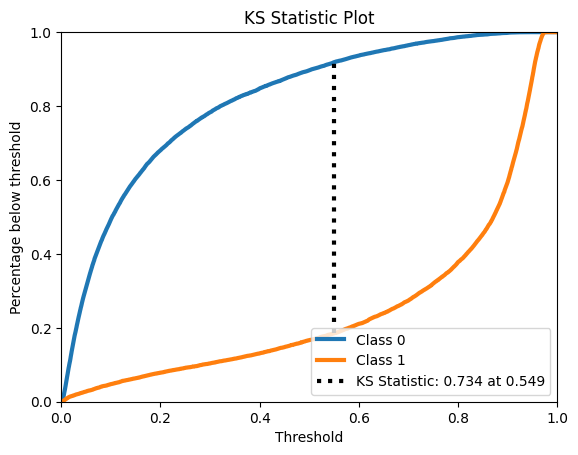

[I 2024-07-29 17:28:41,540] Trial 16 finished with values: [0.9250916034139169, 0.7337628178218162] and parameters: {'n_hidden_layers': 140, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 96}. 




MLP
n_hidden_layers: 140
activation_function:sigmoid
optimizer:adam
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9251
AUPR:             0.9291
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5213 - loss: 0.6933 - val_accuracy: 0.7099 - val_loss: 0.6855
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.6433 - loss: 0.6834 - val_accuracy: 0.7518 - val_loss: 0.6735
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.7071 - loss: 0.6692 - val_accuracy: 0.7677 - val_loss: 0.6504
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.7214 - loss: 0.6430 - val_accuracy: 0.7810 - val_loss: 0.6026
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.7224 - loss: 0.5970 - val_accuracy: 0.7874 - val_loss: 0.5471
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


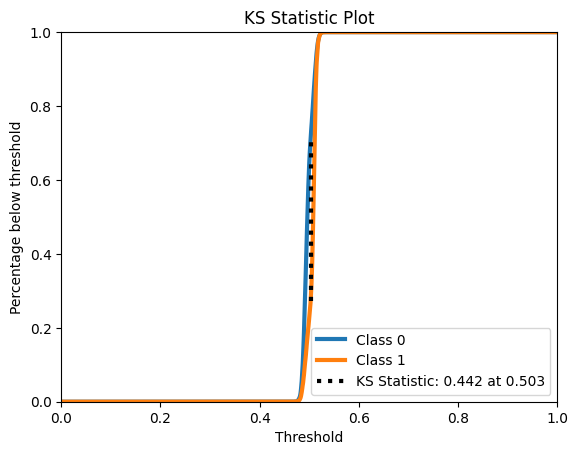

[I 2024-07-29 17:28:46,045] Trial 17 finished with values: [0.7249908946004093, 0.44179938484561565] and parameters: {'n_hidden_layers': 20, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 20
activation_function:softmax
optimizer:SGD
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.7250
AUPR:             0.6032
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 915us/step - accuracy: 0.8678 - loss: 0.3176 - val_accuracy: 0.9261 - val_loss: 0.1825
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.9252 - loss: 0.1811 - val_accuracy: 0.9265 - val_loss: 0.1606
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - accuracy: 0.9355 - loss: 0.1538 - val_accuracy: 0.9397 - val_loss: 0.1496
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - accuracy: 0.9387 - loss: 0.1418 - val_accuracy: 0.9395 - val_loss: 0.1344
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.9434 - loss: 0.1330 - val_accuracy: 0.9473 - val_loss: 0.1311
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step


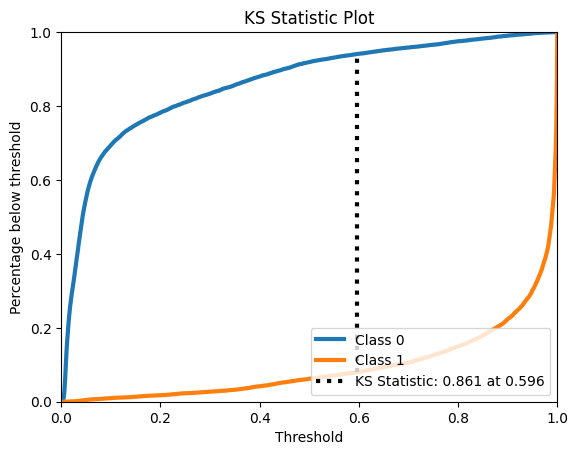

[I 2024-07-29 17:28:58,014] Trial 18 finished with values: [0.9815294891011622, 0.8613407835380629] and parameters: {'n_hidden_layers': 490, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 490
activation_function:relu
optimizer:adam
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9815
AUPR:             0.9790
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.8197 - loss: 0.4129 - val_accuracy: 0.8743 - val_loss: 0.3116
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.8928 - loss: 0.2700 - val_accuracy: 0.9102 - val_loss: 0.2216
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.9085 - loss: 0.2253 - val_accuracy: 0.9235 - val_loss: 0.1915
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.9240 - loss: 0.1913 - val_accuracy: 0.9310 - val_loss: 0.1761
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - accuracy: 0.9273 - loss: 0.1789 - val_accuracy: 0.9332 - val_loss: 0.1649
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step


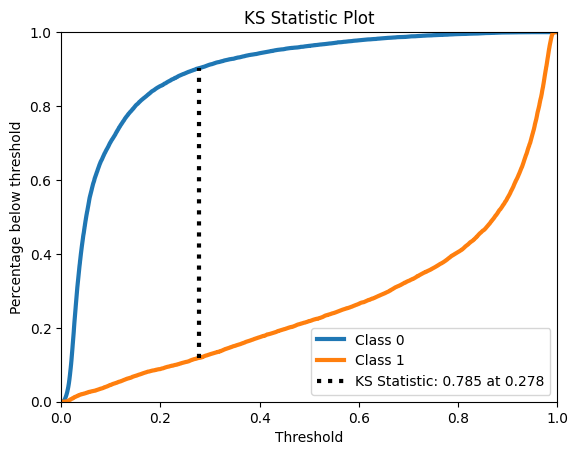

[I 2024-07-29 17:29:02,449] Trial 19 finished with values: [0.9511436061094449, 0.784570918585338] and parameters: {'n_hidden_layers': 100, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 100
activation_function:relu
optimizer:rmsprop
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9511
AUPR:             0.9515
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8442 - loss: 0.3602 - val_accuracy: 0.9135 - val_loss: 0.2113
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.9171 - loss: 0.2028 - val_accuracy: 0.9224 - val_loss: 0.1785
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.9309 - loss: 0.1687 - val_accuracy: 0.9391 - val_loss: 0.1494
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.9355 - loss: 0.1572 - val_accuracy: 0.9410 - val_loss: 0.1424
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.9391 - loss: 0.1440 - val_accuracy: 0.9433 - val_loss: 0.1409
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step


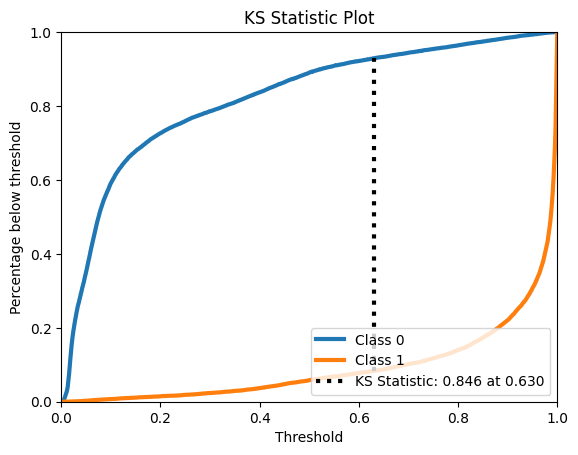

[I 2024-07-29 17:29:09,582] Trial 20 finished with values: [0.9771052062356553, 0.8463275450635587] and parameters: {'n_hidden_layers': 310, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 310
activation_function:relu
optimizer:adam
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9771
AUPR:             0.9739
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7247 - loss: 0.5743 - val_accuracy: 0.8632 - val_loss: 0.3660
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.8463 - loss: 0.3870 - val_accuracy: 0.8723 - val_loss: 0.3324
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.8653 - loss: 0.3473 - val_accuracy: 0.8764 - val_loss: 0.3131
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.8674 - loss: 0.3332 - val_accuracy: 0.8866 - val_loss: 0.2863
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.8816 - loss: 0.3069 - val_accuracy: 0.9004 - val_loss: 0.2567
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


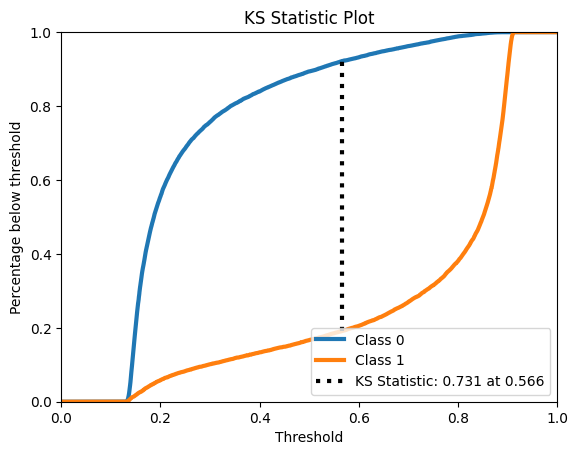

[I 2024-07-29 17:29:16,660] Trial 21 finished with values: [0.9242876329844918, 0.7305959890087985] and parameters: {'n_hidden_layers': 240, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 240
activation_function:softmax
optimizer:adam
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9243
AUPR:             0.9286
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6534 - loss: 0.6804 - val_accuracy: 0.8133 - val_loss: 0.5312
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7962 - loss: 0.5018 - val_accuracy: 0.8351 - val_loss: 0.4094
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8354 - loss: 0.4083 - val_accuracy: 0.8621 - val_loss: 0.3523
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8554 - loss: 0.3656 - val_accuracy: 0.8694 - val_loss: 0.3304
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8614 - loss: 0.3469 - val_accuracy: 0.8757 - val_loss: 0.3184
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step


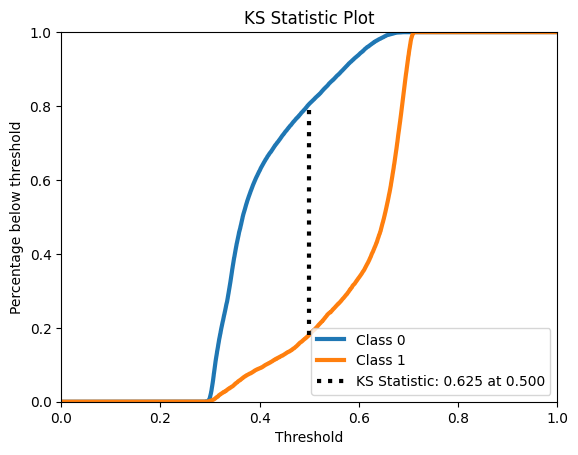

[I 2024-07-29 17:29:21,543] Trial 22 finished with values: [0.8927209596815735, 0.6250438274983635] and parameters: {'n_hidden_layers': 370, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 370
activation_function:softmax
optimizer:rmsprop
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8927
AUPR:             0.8925
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8336 - loss: 0.3867 - val_accuracy: 0.8966 - val_loss: 0.2571
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.9062 - loss: 0.2342 - val_accuracy: 0.9134 - val_loss: 0.2072
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.9220 - loss: 0.1991 - val_accuracy: 0.9318 - val_loss: 0.1715
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.9270 - loss: 0.1742 - val_accuracy: 0.9369 - val_loss: 0.1593
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9330 - loss: 0.1620 - val_accuracy: 0.9369 - val_loss: 0.1499
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step


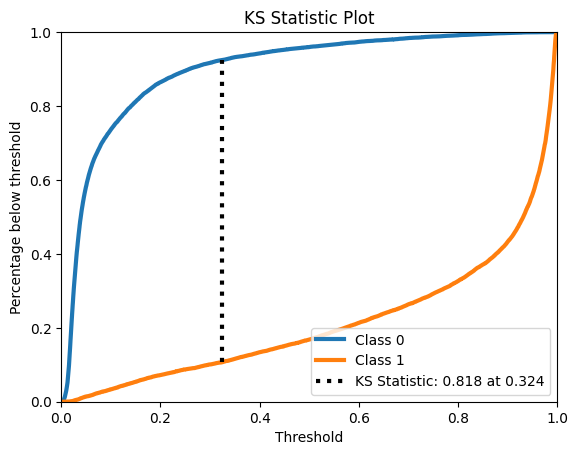

[I 2024-07-29 17:29:27,214] Trial 23 finished with values: [0.9670190091219836, 0.8181426578369276] and parameters: {'n_hidden_layers': 190, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 190
activation_function:relu
optimizer:rmsprop
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9670
AUPR:             0.9640
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.6035 - loss: 0.6582 - val_accuracy: 0.8028 - val_loss: 0.4940
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.7674 - loss: 0.5089 - val_accuracy: 0.8176 - val_loss: 0.4324
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - accuracy: 0.7967 - loss: 0.4622 - val_accuracy: 0.8263 - val_loss: 0.4079
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8062 - loss: 0.4430 - val_accuracy: 0.8388 - val_loss: 0.3931
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.8184 - loss: 0.4249 - val_accuracy: 0.8449 - val_loss: 0.3830
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step


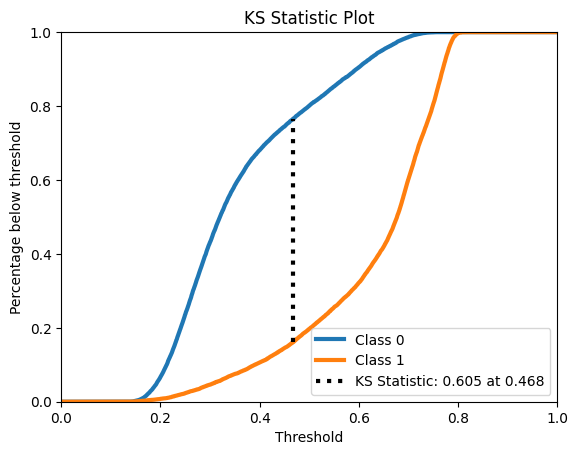

[I 2024-07-29 17:29:33,508] Trial 24 finished with values: [0.8855179631393382, 0.6049307854713426] and parameters: {'n_hidden_layers': 190, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 190
activation_function:sigmoid
optimizer:SGD
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8855
AUPR:             0.8765
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6907 - loss: 0.6353 - val_accuracy: 0.8363 - val_loss: 0.4432
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8297 - loss: 0.4300 - val_accuracy: 0.8627 - val_loss: 0.3615
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8532 - loss: 0.3760 - val_accuracy: 0.8680 - val_loss: 0.3370
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8622 - loss: 0.3575 - val_accuracy: 0.8722 - val_loss: 0.3266
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8664 - loss: 0.3430 - val_accuracy: 0.8752 - val_loss: 0.3173
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


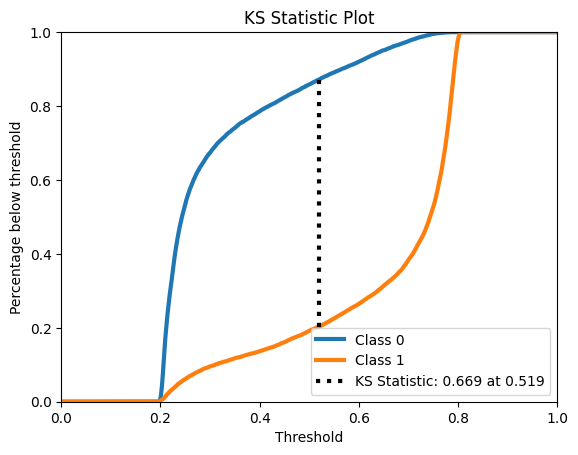

[I 2024-07-29 17:29:38,950] Trial 25 finished with values: [0.9077525732112672, 0.6694852688823177] and parameters: {'n_hidden_layers': 360, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 160}. 




MLP
n_hidden_layers: 360
activation_function:softmax
optimizer:adam
batch_size:160

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9078
AUPR:             0.9090
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.7282 - loss: 0.5371 - val_accuracy: 0.8602 - val_loss: 0.3737
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.8450 - loss: 0.3877 - val_accuracy: 0.8641 - val_loss: 0.3484
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.8551 - loss: 0.3683 - val_accuracy: 0.8673 - val_loss: 0.3395
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.8571 - loss: 0.3570 - val_accuracy: 0.8716 - val_loss: 0.3339
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.8608 - loss: 0.3486 - val_accuracy: 0.8727 - val_loss: 0.3256
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step


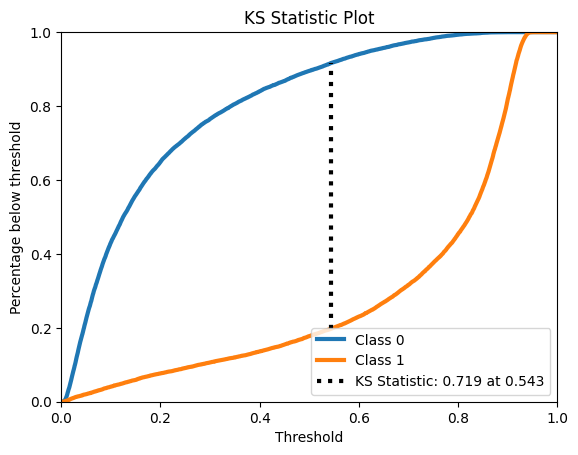

[I 2024-07-29 17:29:43,484] Trial 26 finished with values: [0.9214833679442553, 0.719245053445759] and parameters: {'n_hidden_layers': 30, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 30
activation_function:sigmoid
optimizer:rmsprop
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9215
AUPR:             0.9253
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 769us/step - accuracy: 0.7822 - loss: 0.4644 - val_accuracy: 0.8645 - val_loss: 0.3371
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 732us/step - accuracy: 0.8625 - loss: 0.3411 - val_accuracy: 0.8781 - val_loss: 0.3088
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 749us/step - accuracy: 0.8762 - loss: 0.3117 - val_accuracy: 0.8917 - val_loss: 0.2830
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 736us/step - accuracy: 0.8888 - loss: 0.2839 - val_accuracy: 0.9011 - val_loss: 0.2587
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 738us/step - accuracy: 0.8977 - loss: 0.2610 - val_accuracy: 0.9082 - val_loss: 0.2396
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 509us/step


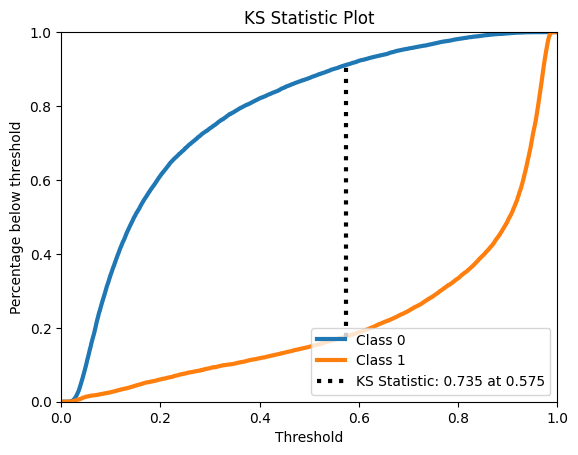

[I 2024-07-29 17:29:53,202] Trial 27 finished with values: [0.9282672163525822, 0.7349606899857929] and parameters: {'n_hidden_layers': 250, 'activation_function': 'relu', 'optimizer': 'SGD', 'batch_size': 32}. 




MLP
n_hidden_layers: 250
activation_function:relu
optimizer:SGD
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9283
AUPR:             0.9320
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - accuracy: 0.8221 - loss: 0.4084 - val_accuracy: 0.8677 - val_loss: 0.3380
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.8655 - loss: 0.3453 - val_accuracy: 0.8781 - val_loss: 0.3225
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - accuracy: 0.8713 - loss: 0.3284 - val_accuracy: 0.8925 - val_loss: 0.2877
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.8818 - loss: 0.2987 - val_accuracy: 0.8983 - val_loss: 0.2581
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.8865 - loss: 0.2782 - val_accuracy: 0.9062 - val_loss: 0.2369
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step


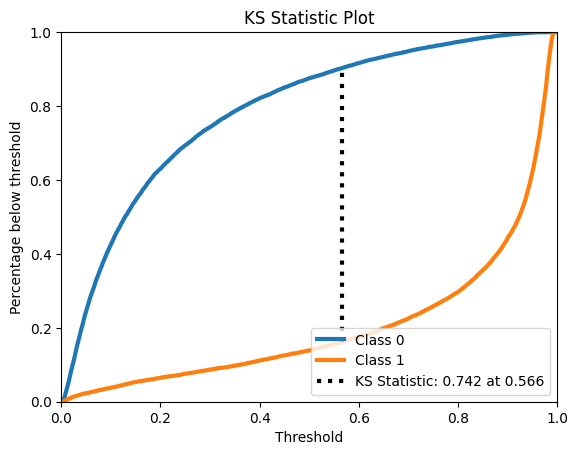

[I 2024-07-29 17:29:59,417] Trial 28 finished with values: [0.9282189895533216, 0.7416186904977544] and parameters: {'n_hidden_layers': 120, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 120
activation_function:tanh
optimizer:adam
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9282
AUPR:             0.9323
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7085 - loss: 0.6345 - val_accuracy: 0.8250 - val_loss: 0.4472
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8271 - loss: 0.4315 - val_accuracy: 0.8615 - val_loss: 0.3554
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.8536 - loss: 0.3670 - val_accuracy: 0.8704 - val_loss: 0.3265
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8689 - loss: 0.3385 - val_accuracy: 0.8793 - val_loss: 0.3070
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.8746 - loss: 0.3220 - val_accuracy: 0.8876 - val_loss: 0.2922
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step


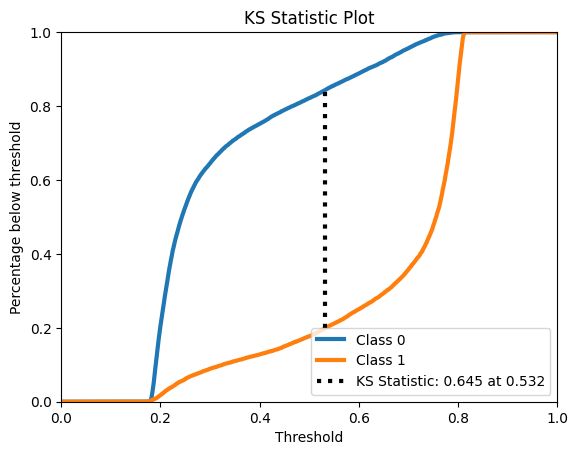

[I 2024-07-29 17:30:04,510] Trial 29 finished with values: [0.9010621152488789, 0.645475120848897] and parameters: {'n_hidden_layers': 110, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 96}. 




MLP
n_hidden_layers: 110
activation_function:softmax
optimizer:rmsprop
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9011
AUPR:             0.8998
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8572 - loss: 0.3408 - val_accuracy: 0.9201 - val_loss: 0.1989
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9177 - loss: 0.1996 - val_accuracy: 0.9289 - val_loss: 0.1638
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9290 - loss: 0.1676 - val_accuracy: 0.9330 - val_loss: 0.1512
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.9371 - loss: 0.1506 - val_accuracy: 0.9399 - val_loss: 0.1398
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.9399 - loss: 0.1420 - val_accuracy: 0.9448 - val_loss: 0.1315
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


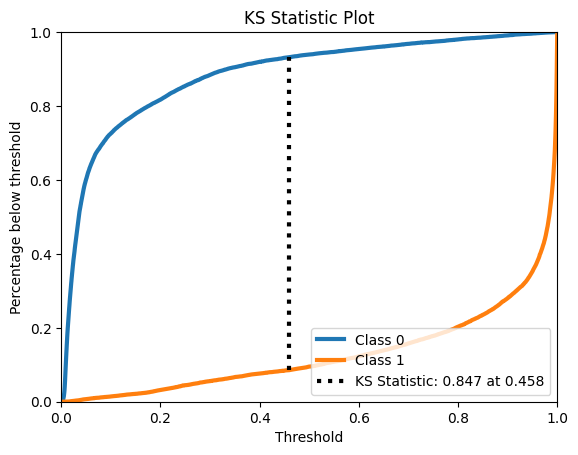

[I 2024-07-29 17:30:12,510] Trial 30 finished with values: [0.977296353133293, 0.8468477521407026] and parameters: {'n_hidden_layers': 460, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 460
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9773
AUPR:             0.9739
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7731 - loss: 0.4795 - val_accuracy: 0.8539 - val_loss: 0.3534
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8500 - loss: 0.3744 - val_accuracy: 0.8640 - val_loss: 0.3476
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8552 - loss: 0.3657 - val_accuracy: 0.8701 - val_loss: 0.3511
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8561 - loss: 0.3694 - val_accuracy: 0.8376 - val_loss: 0.3705
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8549 - loss: 0.3637 - val_accuracy: 0.8589 - val_loss: 0.3483
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step


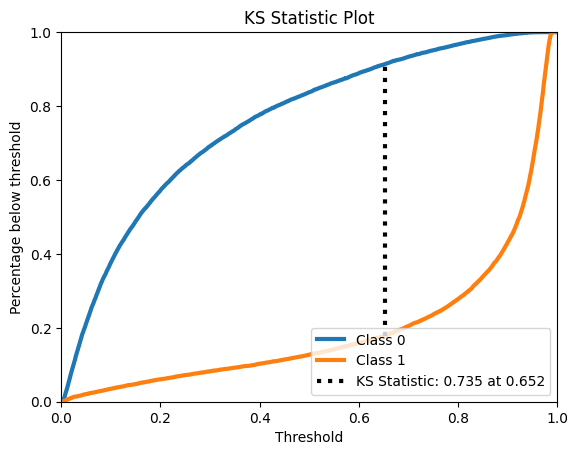

[I 2024-07-29 17:30:18,136] Trial 31 finished with values: [0.9248976790263195, 0.7351377236057475] and parameters: {'n_hidden_layers': 500, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 500
activation_function:sigmoid
optimizer:rmsprop
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9249
AUPR:             0.9298
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 967us/step - accuracy: 0.8177 - loss: 0.4203 - val_accuracy: 0.8615 - val_loss: 0.3483
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8553 - loss: 0.3691 - val_accuracy: 0.8644 - val_loss: 0.3434
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.8616 - loss: 0.3535 - val_accuracy: 0.8722 - val_loss: 0.3257
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8692 - loss: 0.3281 - val_accuracy: 0.8833 - val_loss: 0.2876
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - accuracy: 0.8838 - loss: 0.2942 - val_accuracy: 0.9008 - val_loss: 0.2484
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step


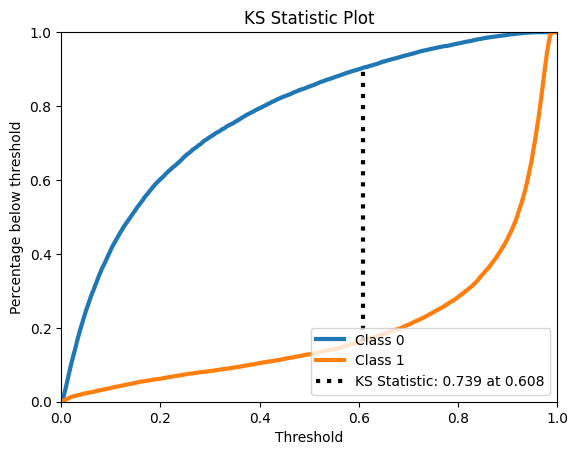

[I 2024-07-29 17:30:32,263] Trial 32 finished with values: [0.9269278369621191, 0.7389189007713088] and parameters: {'n_hidden_layers': 480, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32}. 




MLP
n_hidden_layers: 480
activation_function:sigmoid
optimizer:adam
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9269
AUPR:             0.9312
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8239 - loss: 0.4113 - val_accuracy: 0.8616 - val_loss: 0.3440
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8609 - loss: 0.3551 - val_accuracy: 0.8527 - val_loss: 0.3522
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8636 - loss: 0.3517 - val_accuracy: 0.8698 - val_loss: 0.3368
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8622 - loss: 0.3522 - val_accuracy: 0.8725 - val_loss: 0.3383
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8678 - loss: 0.3394 - val_accuracy: 0.8770 - val_loss: 0.3140
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step


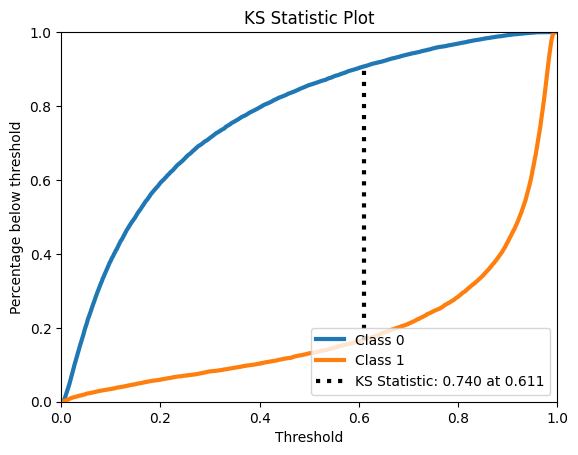

[I 2024-07-29 17:30:36,915] Trial 33 finished with values: [0.9269072229296168, 0.7401625600213361] and parameters: {'n_hidden_layers': 230, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 128}. 




MLP
n_hidden_layers: 230
activation_function:tanh
optimizer:rmsprop
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9269
AUPR:             0.9309
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8023 - loss: 0.4459 - val_accuracy: 0.8328 - val_loss: 0.3763
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.8546 - loss: 0.3675 - val_accuracy: 0.8698 - val_loss: 0.3510
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.8602 - loss: 0.3615 - val_accuracy: 0.8681 - val_loss: 0.3430
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.8597 - loss: 0.3548 - val_accuracy: 0.8714 - val_loss: 0.3431
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.8603 - loss: 0.3529 - val_accuracy: 0.8722 - val_loss: 0.3363
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step


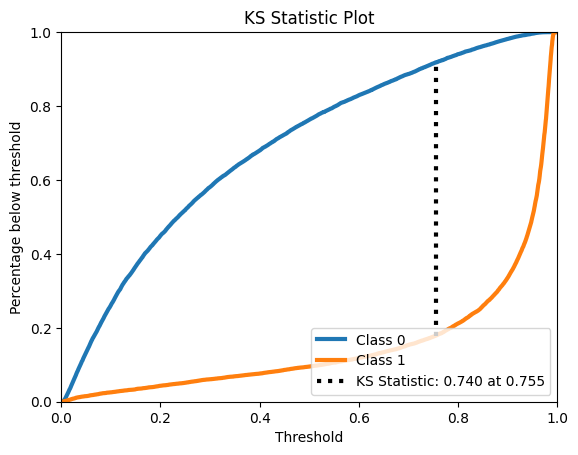

[I 2024-07-29 17:30:44,458] Trial 34 finished with values: [0.9261373583011577, 0.7395435986034664] and parameters: {'n_hidden_layers': 360, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 360
activation_function:sigmoid
optimizer:rmsprop
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9261
AUPR:             0.9310
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7715 - loss: 0.4895 - val_accuracy: 0.8544 - val_loss: 0.3641
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.8506 - loss: 0.3685 - val_accuracy: 0.8647 - val_loss: 0.3471
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - accuracy: 0.8585 - loss: 0.3547 - val_accuracy: 0.8681 - val_loss: 0.3441
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.8628 - loss: 0.3546 - val_accuracy: 0.8685 - val_loss: 0.3425
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8657 - loss: 0.3489 - val_accuracy: 0.8685 - val_loss: 0.3415
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step


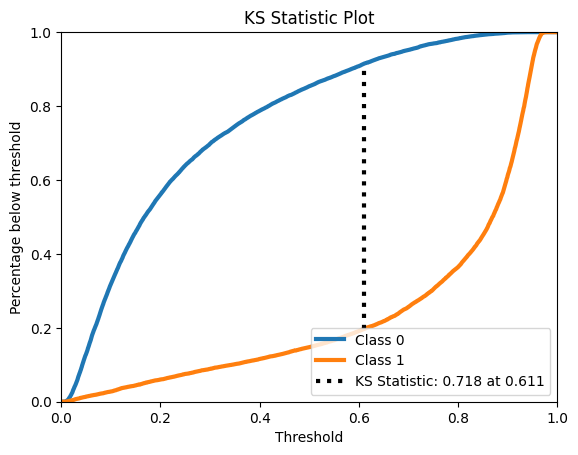

[I 2024-07-29 17:30:52,057] Trial 35 finished with values: [0.9208592144152029, 0.7180798510490233] and parameters: {'n_hidden_layers': 220, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 220
activation_function:tanh
optimizer:SGD
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9209
AUPR:             0.9245
Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5092 - loss: 0.6930 - val_accuracy: 0.6534 - val_loss: 0.6930
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5227 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5156 - loss: 0.6929 - val_accuracy: 0.6702 - val_loss: 0.6929
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5220 - loss: 0.6928 - val_accuracy: 0.7520 - val_loss: 0.6928
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step


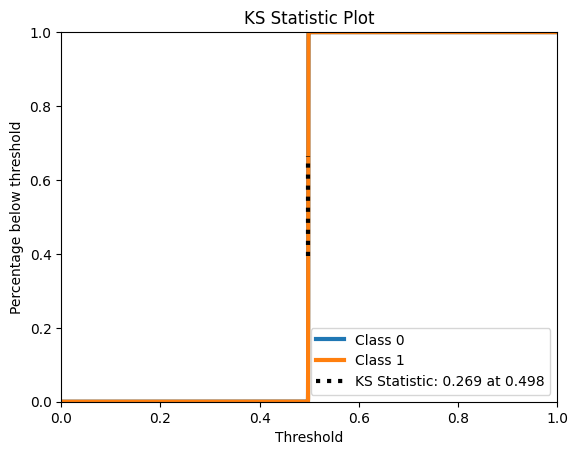

[I 2024-07-29 17:30:57,972] Trial 36 finished with values: [0.6735108825357187, 0.2687118967800885] and parameters: {'n_hidden_layers': 350, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 96}. 




MLP
n_hidden_layers: 350
activation_function:softmax
optimizer:SGD
batch_size:96

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.6735
AUPR:             0.5902
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6356 - loss: 0.6770 - val_accuracy: 0.8114 - val_loss: 0.5366
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7944 - loss: 0.5097 - val_accuracy: 0.8351 - val_loss: 0.4197
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8239 - loss: 0.4236 - val_accuracy: 0.8621 - val_loss: 0.3633
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8430 - loss: 0.3838 - val_accuracy: 0.8689 - val_loss: 0.3375
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8540 - loss: 0.3603 - val_accuracy: 0.8730 - val_loss: 0.3272
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step


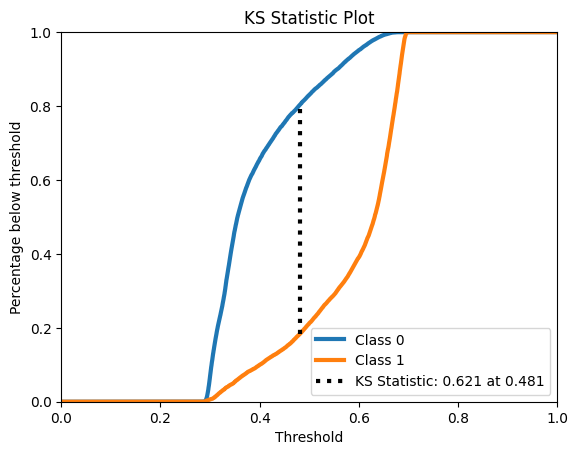

[I 2024-07-29 17:31:02,463] Trial 37 finished with values: [0.8887962563496383, 0.6205910652274659] and parameters: {'n_hidden_layers': 240, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 240
activation_function:softmax
optimizer:rmsprop
batch_size:160

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8888
AUPR:             0.8834
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7004 - loss: 0.6211 - val_accuracy: 0.8457 - val_loss: 0.4170
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8449 - loss: 0.4067 - val_accuracy: 0.8672 - val_loss: 0.3467
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8608 - loss: 0.3613 - val_accuracy: 0.8741 - val_loss: 0.3237
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8673 - loss: 0.3410 - val_accuracy: 0.8828 - val_loss: 0.3060
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8727 - loss: 0.3261 - val_accuracy: 0.8870 - val_loss: 0.2926
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step


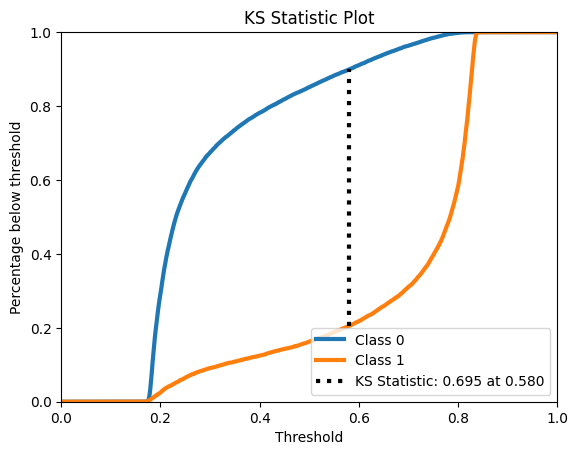

[I 2024-07-29 17:31:07,642] Trial 38 finished with values: [0.9150622222797151, 0.6946798166127801] and parameters: {'n_hidden_layers': 290, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 128}. 




MLP
n_hidden_layers: 290
activation_function:softmax
optimizer:adam
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9151
AUPR:             0.9180
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7210 - loss: 0.5517 - val_accuracy: 0.8350 - val_loss: 0.4000
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8320 - loss: 0.4008 - val_accuracy: 0.8540 - val_loss: 0.3648
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.8503 - loss: 0.3707 - val_accuracy: 0.8614 - val_loss: 0.3523
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.8574 - loss: 0.3616 - val_accuracy: 0.8625 - val_loss: 0.3475
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.8600 - loss: 0.3562 - val_accuracy: 0.8683 - val_loss: 0.3457
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step


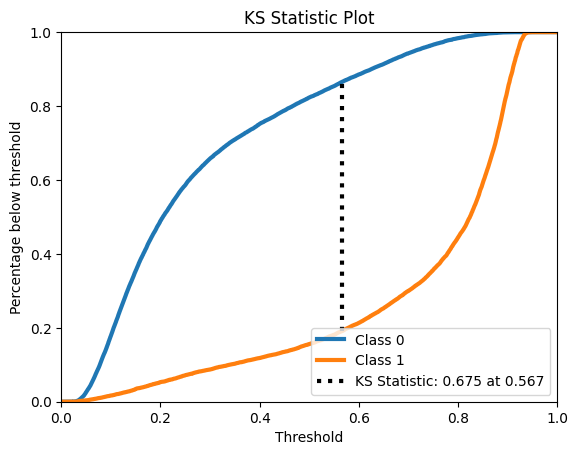

[I 2024-07-29 17:31:11,974] Trial 39 finished with values: [0.907578243735464, 0.6745481331694757] and parameters: {'n_hidden_layers': 170, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 128}. 




MLP
n_hidden_layers: 170
activation_function:tanh
optimizer:SGD
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9076
AUPR:             0.9062
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 861us/step - accuracy: 0.8405 - loss: 0.3856 - val_accuracy: 0.8599 - val_loss: 0.3444
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 854us/step - accuracy: 0.8577 - loss: 0.3582 - val_accuracy: 0.8642 - val_loss: 0.3340
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - accuracy: 0.8668 - loss: 0.3379 - val_accuracy: 0.8854 - val_loss: 0.2946
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 832us/step - accuracy: 0.8806 - loss: 0.3036 - val_accuracy: 0.8990 - val_loss: 0.2591
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.8854 - loss: 0.2817 - val_accuracy: 0.9059 - val_loss: 0.2372
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step


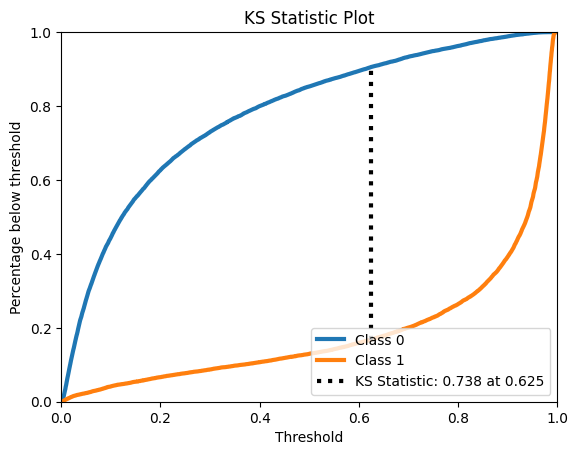

[I 2024-07-29 17:31:22,868] Trial 40 finished with values: [0.9270294749512116, 0.7376289101321255] and parameters: {'n_hidden_layers': 260, 'activation_function': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 260
activation_function:tanh
optimizer:rmsprop
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9270
AUPR:             0.9310
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.5750 - loss: 0.6918 - val_accuracy: 0.6322 - val_loss: 0.6911
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.6117 - loss: 0.6910 - val_accuracy: 0.7191 - val_loss: 0.6902
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.6473 - loss: 0.6900 - val_accuracy: 0.6147 - val_loss: 0.6891
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.6424 - loss: 0.6889 - val_accuracy: 0.7154 - val_loss: 0.6877
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.6761 - loss: 0.6872 - val_accuracy: 0.7912 - val_loss: 0.6854
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step


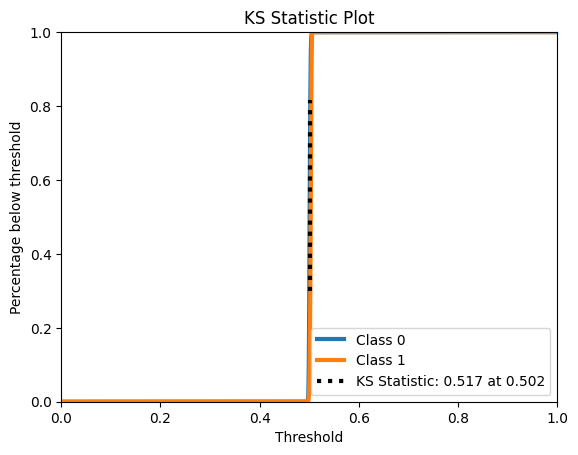

[I 2024-07-29 17:31:29,130] Trial 41 finished with values: [0.8310932654839824, 0.5167755162858751] and parameters: {'n_hidden_layers': 100, 'activation_function': 'softmax', 'optimizer': 'SGD', 'batch_size': 64}. 




MLP
n_hidden_layers: 100
activation_function:softmax
optimizer:SGD
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8311
AUPR:             0.7961
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7353 - loss: 0.5519 - val_accuracy: 0.8208 - val_loss: 0.4118
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8213 - loss: 0.4083 - val_accuracy: 0.8490 - val_loss: 0.3694
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8453 - loss: 0.3736 - val_accuracy: 0.8607 - val_loss: 0.3490
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8573 - loss: 0.3528 - val_accuracy: 0.8677 - val_loss: 0.3378
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8630 - loss: 0.3448 - val_accuracy: 0.8701 - val_loss: 0.3294
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step


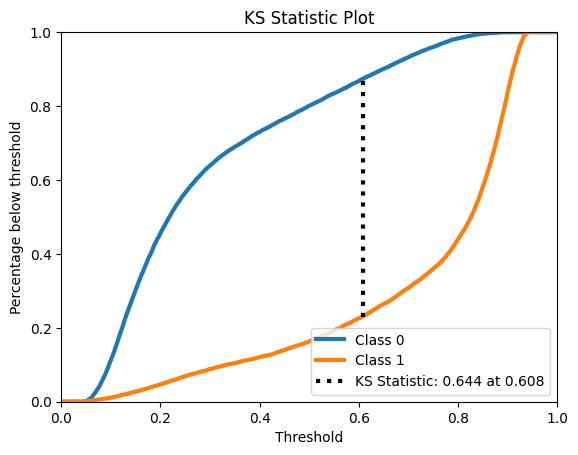

[I 2024-07-29 17:31:33,714] Trial 42 finished with values: [0.9012584079340308, 0.6435656244887388] and parameters: {'n_hidden_layers': 500, 'activation_function': 'relu', 'optimizer': 'SGD', 'batch_size': 128}. 




MLP
n_hidden_layers: 500
activation_function:relu
optimizer:SGD
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9013
AUPR:             0.9004
Epoch 1/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7471 - loss: 0.5255 - val_accuracy: 0.8319 - val_loss: 0.3945
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8352 - loss: 0.3931 - val_accuracy: 0.8529 - val_loss: 0.3628
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8511 - loss: 0.3708 - val_accuracy: 0.8584 - val_loss: 0.3524
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8614 - loss: 0.3540 - val_accuracy: 0.8632 - val_loss: 0.3477
Epoch 5/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8636 - loss: 0.3533 - val_accuracy: 0.8650 - val_loss: 0.3454
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step


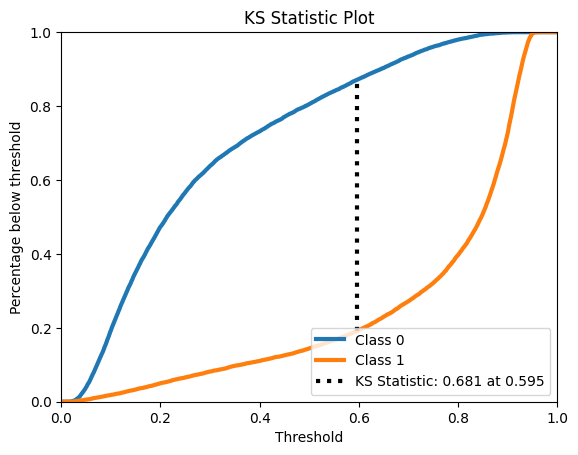

[I 2024-07-29 17:31:38,624] Trial 43 finished with values: [0.9100292792221312, 0.6805125950175166] and parameters: {'n_hidden_layers': 400, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 128}. 




MLP
n_hidden_layers: 400
activation_function:tanh
optimizer:SGD
batch_size:128

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9100
AUPR:             0.9112
Epoch 1/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 820us/step - accuracy: 0.8550 - loss: 0.3478 - val_accuracy: 0.9106 - val_loss: 0.2194
Epoch 2/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 857us/step - accuracy: 0.9147 - loss: 0.2063 - val_accuracy: 0.9222 - val_loss: 0.1855
Epoch 3/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - accuracy: 0.9314 - loss: 0.1701 - val_accuracy: 0.9363 - val_loss: 0.1536
Epoch 4/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - accuracy: 0.9354 - loss: 0.1565 - val_accuracy: 0.9345 - val_loss: 0.1613
Epoch 5/100
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step - accuracy: 0.9394 - loss: 0.1446 - val_accuracy: 0.9392 - val_loss: 0.1420
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step


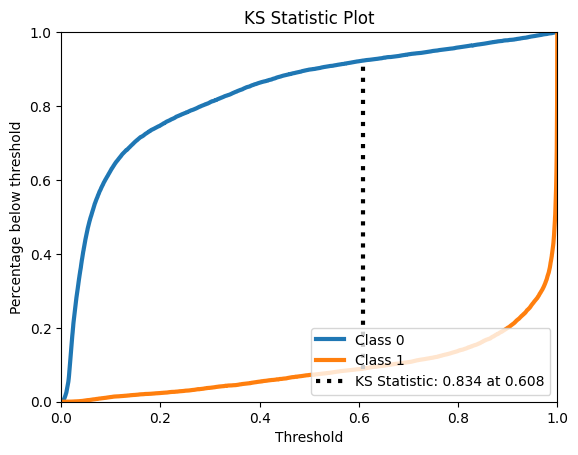

[I 2024-07-29 17:31:49,210] Trial 44 finished with values: [0.9741466293348854, 0.8336255140822195] and parameters: {'n_hidden_layers': 240, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32}. 




MLP
n_hidden_layers: 240
activation_function:relu
optimizer:rmsprop
batch_size:32

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9741
AUPR:             0.9710
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.7983 - loss: 0.4475 - val_accuracy: 0.8637 - val_loss: 0.3498
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.8545 - loss: 0.3680 - val_accuracy: 0.8650 - val_loss: 0.3463
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.8596 - loss: 0.3582 - val_accuracy: 0.8589 - val_loss: 0.3465
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.8598 - loss: 0.3580 - val_accuracy: 0.8709 - val_loss: 0.3439
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.8617 - loss: 0.3512 - val_accuracy: 0.8658 - val_loss: 0.3336
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step


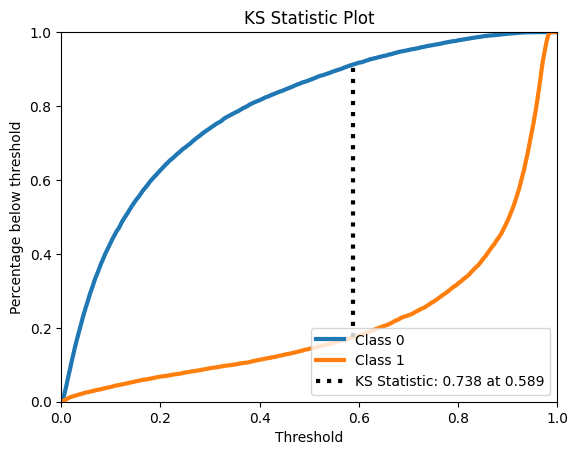

[I 2024-07-29 17:31:55,820] Trial 45 finished with values: [0.9260021568840516, 0.7381867783517962] and parameters: {'n_hidden_layers': 320, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 320
activation_function:sigmoid
optimizer:rmsprop
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9260
AUPR:             0.9306
Epoch 1/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6088 - loss: 0.6835 - val_accuracy: 0.8176 - val_loss: 0.5675
Epoch 2/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7544 - loss: 0.5449 - val_accuracy: 0.8343 - val_loss: 0.4373
Epoch 3/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7660 - loss: 0.4537 - val_accuracy: 0.8584 - val_loss: 0.3775
Epoch 4/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8021 - loss: 0.4079 - val_accuracy: 0.8653 - val_loss: 0.3483
Epoch 5/100
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8401 - loss: 0.3838 - val_accuracy: 0.8684 - val_loss: 0.3366
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step


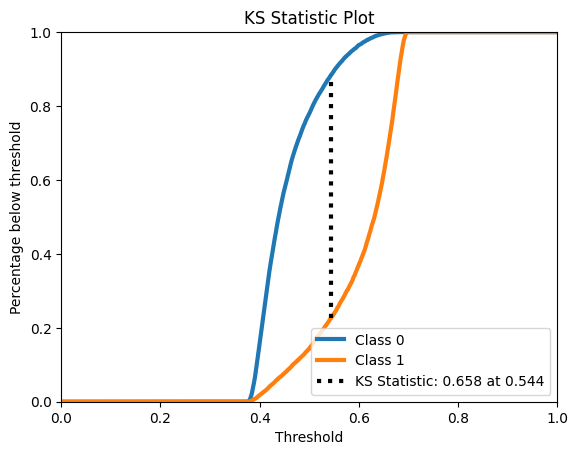

[I 2024-07-29 17:32:00,206] Trial 46 finished with values: [0.8995005964963688, 0.658330019936433] and parameters: {'n_hidden_layers': 430, 'activation_function': 'softmax', 'optimizer': 'rmsprop', 'batch_size': 160}. 




MLP
n_hidden_layers: 430
activation_function:softmax
optimizer:rmsprop
batch_size:160

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.8995
AUPR:             0.9003
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.8194 - loss: 0.4047 - val_accuracy: 0.9021 - val_loss: 0.2491
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.9020 - loss: 0.2436 - val_accuracy: 0.9159 - val_loss: 0.2063
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step - accuracy: 0.9157 - loss: 0.2063 - val_accuracy: 0.9234 - val_loss: 0.1884
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - accuracy: 0.9216 - loss: 0.1885 - val_accuracy: 0.9335 - val_loss: 0.1652
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.9296 - loss: 0.1710 - val_accuracy: 0.9354 - val_loss: 0.1545
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step


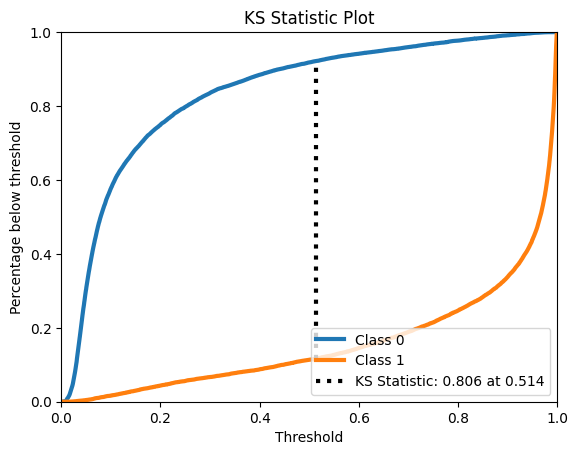

[I 2024-07-29 17:32:05,872] Trial 47 finished with values: [0.9626937102853921, 0.805528498994512] and parameters: {'n_hidden_layers': 80, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. 




MLP
n_hidden_layers: 80
activation_function:relu
optimizer:rmsprop
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9627
AUPR:             0.9601
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8390 - loss: 0.3844 - val_accuracy: 0.8692 - val_loss: 0.3480
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8631 - loss: 0.3557 - val_accuracy: 0.8631 - val_loss: 0.3413
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8657 - loss: 0.3423 - val_accuracy: 0.8824 - val_loss: 0.3182
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8752 - loss: 0.3208 - val_accuracy: 0.8930 - val_loss: 0.2799
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8797 - loss: 0.3011 - val_accuracy: 0.9012 - val_loss: 0.2531
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step


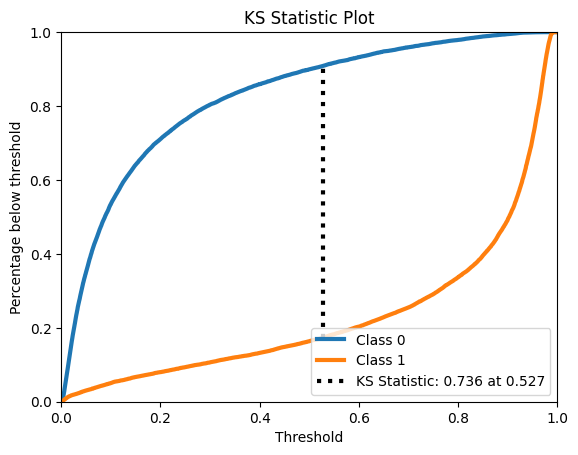

[I 2024-07-29 17:32:13,500] Trial 48 finished with values: [0.9270392801277202, 0.7359619645004665] and parameters: {'n_hidden_layers': 470, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 470
activation_function:tanh
optimizer:adam
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9270
AUPR:             0.9302
Epoch 1/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7851 - loss: 0.5724 - val_accuracy: 0.8628 - val_loss: 0.3613
Epoch 2/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8577 - loss: 0.3666 - val_accuracy: 0.8727 - val_loss: 0.3264
Epoch 3/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8655 - loss: 0.3401 - val_accuracy: 0.8807 - val_loss: 0.2959
Epoch 4/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8784 - loss: 0.3040 - val_accuracy: 0.8982 - val_loss: 0.2608
Epoch 5/100
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8902 - loss: 0.2791 - val_accuracy: 0.9079 - val_loss: 0.2385
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step


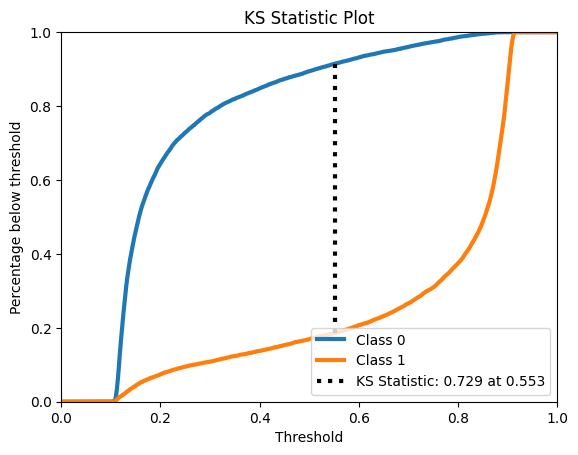

[I 2024-07-29 17:32:21,064] Trial 49 finished with values: [0.9240244296204331, 0.7288433831933894] and parameters: {'n_hidden_layers': 480, 'activation_function': 'softmax', 'optimizer': 'adam', 'batch_size': 64}. 




MLP
n_hidden_layers: 480
activation_function:softmax
optimizer:adam
batch_size:64

Accuracy:         0.9489
Recall:           0.9412
Precision:        0.9411
F1:               0.9412
AUROC:            0.9240
AUPR:             0.9279


In [24]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=50)

#### Salvando os resultados no csv e visualizando os resultados

In [85]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "../results/optuna_results_mlp.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [86]:
df_existing

,number,values_0,values_1,params_activation_function,params_batch_size,params_n_hidden_layers,params_optimizer,user_attrs_accuracy,user_attrs_activation_function,user_attrs_auroc,user_attrs_batch_size,user_attrs_f1,user_attrs_ks_statistic,user_attrs_max_distance_at,user_attrs_n_hidden_layers,user_attrs_optimizer,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
10,10,0.431994,0.045550,softmax,64,220,SGD,0.950724,softmax,0.431994,64,0.948055,0.045550,0.500170,220,SGD,0.948055,0.937974,0
3,3,0.463689,0.050850,softmax,64,280,SGD,0.950724,softmax,0.463689,64,0.948055,0.050850,0.499692,280,SGD,0.948055,0.937974,0
37,37,0.675989,0.266699,softmax,64,180,SGD,0.950724,softmax,0.675989,64,0.948055,0.266699,0.500848,180,SGD,0.948055,0.937974,0
39,39,0.820313,0.506949,softmax,64,40,SGD,0.950724,softmax,0.820313,64,0.948055,0.506949,0.505659,40,SGD,0.948055,0.937974,0
46,46,0.837507,0.532143,sigmoid,128,320,SGD,0.950724,sigmoid,0.837507,128,0.948055,0.532143,0.496873,320,SGD,0.948055,0.937974,0
44,44,0.851985,0.569943,sigmoid,96,320,SGD,0.950724,sigmoid,0.851985,96,0.948055,0.569943,0.495476,320,SGD,0.948055,0.937974,0
28,28,0.864162,0.576904,tanh,64,310,SGD,0.950724,tanh,0.864162,64,0.948055,0.576904,0.481713,310,SGD,0.948055,0.937974,0
34,34,0.864373,0.574719,tanh,160,500,SGD,0.950724,tanh,0.864373,160,0.948055,0.574719,0.596859,500,SGD,0.948055,0.937974,0
23,23,0.866019,0.571772,tanh,32,330,SGD,0.950724,tanh,0.866019,32,0.948055,0.571772,0.495064,330,SGD,0.948055,0.937974,0
26,26,0.868019,0.583002,tanh,96,460,SGD,0.950724,tanh,0.868019,96,0.948055,0.583002,0.598386,460,SGD,0.948055,0.937974,0


In [87]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9507237449953804
  Precision: 0.9480547395572114
  Recall:    0.9379740554334728
  F1 Score:  0.9480547395572114
  auroc:  0.9906909750735002
  ks_statistic:  0.8998487536082326
  max_distance_at:  0.48135828971862793
  Parameters: 
    n_hidden_layers:  60
    activation_function: relu
    optimizer:        rmsprop
    batch_size:       64

-- Overall Results (Ordered by auroc) --
    number  values_0  values_1 params_activation_function  params_batch_size  \
10      10  0.431994  0.045550                    softmax                 64   
3        3  0.463689  0.050850                    softmax                 64   
37      37  0.675989  0.266699                    softmax                 64   
39      39  0.820313  0.506949                    softmax                 64   
46      46  0.837507  0.532143                    sigmoid                128   
44      44  0.851985  0.569943                    sigmoid                 96   
28      28  0.864162  